In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import os
import h5py
import mahotas
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

images_per_class = 800
fixed_size = (500, 500)
train_path = "dataset/train"
h5_train_data = 'output/train_data.h5'
h5_train_labels = 'output/train_labels.h5'
bins = 8
train_labels = os.listdir(train_path)
train_labels.sort()

global_features = []
labels = []

In [2]:
# Define functions for CNN feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(500, 500, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

In [3]:
class PreprocessImage:
    def preprocess(self, image):
        # Resize the image to a fixed size (500x500 in your case)
        resized_img = cv2.resize(image, (500, 500))

        # Convert the resized image from BGR to RGB
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

        # Convert the RGB image to HSV
        hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    

        # Perform segmentation to extract specific colors (green and brown)
        lower_green = np.array([25, 0, 20])
        upper_green = np.array([100, 255, 255])
        healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
        result = cv2.bitwise_and(rgb_img, rgb_img, mask=healthy_mask)

        lower_brown = np.array([10, 0, 10])
        upper_brown = np.array([30, 255, 255])
        disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
        disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)

        final_mask = healthy_mask + disease_mask
        final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)

        # Convert the final image to grayscale
        gray_img = cv2.cvtColor(final_result, cv2.COLOR_RGB2GRAY)

        # Apply Gaussian Blur to reduce noise
        blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

        # Normalize pixel values to [0, 1] range
        normalized_img = blurred_img.astype('float32') / 255.0

        return normalized_img

preprocessor = PreprocessImage()


In [4]:
def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

In [5]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

In [6]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [7]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [8]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [9]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [10]:
def extract_cnn_features(image):
    # Process the image using your PreprocessImage class
    processed_img = preprocessor.preprocess(image)
    resized_img = cv2.resize(image, (500, 500))  # Resize to 500x500 pixels

# Ensure the image has 3 channels (convert to RGB if needed)
    if resized_img.shape[2] == 1:  # Check if the image is grayscale
       resized_img = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)

# Normalize pixel values to fit the model's requirements
    processed_img = resized_img.astype('float32') / 255.0

# Ensure the shape matches the model's input shape
    processed_img = processed_img.reshape((500, 500, 3))
    # Predict using the model
    features = model.predict(np.array([processed_img]))
    return features.flatten()

In [11]:
input_shape = model.input_shape
print("Model Input Shape:", input_shape)

Model Input Shape: (None, 500, 500, 3)


In [12]:
# Set the number of images to process for each class (for example, 10 images)
num_images_per_class = 50

for training_name in train_labels:
    dir = os.path.join(train_path, training_name)
    current_label = training_name

    # Counter to limit the number of images per class
    count = 0

    for x in range(1, images_per_class + 1):
        # Check if the number of processed images per class reaches the limit
        if count >= num_images_per_class:
            break

        file = dir + "/" + str(x) + ".jpg"
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR, BGR_HSV)

        # Call for Global Feature Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        cnn_feature = extract_cnn_features(image)
        combined_feature = np.hstack([global_feature, cnn_feature])
        global_features.append(combined_feature)
        labels.append(current_label)

        # Increment the counter for the number of processed images
        count += 1

1/1 [==============================] - 1s 748ms/step


In [13]:
# Assuming 'model' is your CNN model object
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

In [14]:

# Convert labels to numerical values
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)

In [15]:
# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)

In [16]:
# Save features and labels to HDF5 files
output_directory = 'output'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

h5f_data = h5py.File(os.path.join(output_directory, 'train_data.h5'), 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

In [17]:
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[STATUS] target labels shape: (100,)


In [18]:
# training
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from joblib import dump, load






warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_train_data    = 'output/train_data.h5'
h5_train_labels  = 'output/train_labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")
# Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
clf.fit(global_features, global_labels)





[STATUS] features shape: (100, 492564)
[STATUS] labels shape: (100,)
[STATUS] training started...


RandomForestClassifier(random_state=9)

In [19]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

[STATUS] splitted train and test data...
Train data  : (80, 492564)
Test data   : (20, 492564)


In [20]:
trainDataGlobal

array([[0.9914727 , 0.15948861, 0.02688554, ..., 0.08083025, 0.        ,
        0.        ],
       [0.91272669, 0.        , 0.        , ..., 0.50559957, 0.        ,
        0.        ],
       [0.97001329, 0.0379672 , 0.00914323, ..., 0.05335846, 0.        ,
        0.        ],
       ...,
       [0.96572909, 0.0133234 , 0.00481279, ..., 0.77481907, 0.        ,
        0.        ],
       [0.90596145, 0.10934269, 0.12946476, ..., 0.48451927, 0.        ,
        0.        ],
       [0.95278548, 0.46066442, 0.11324801, ..., 0.28438931, 0.        ,
        0.        ]])

LR: 0.812500 (0.150520)
LDA: 0.612500 (0.130504)
KNN: 0.550000 (0.169558)
CART: 0.687500 (0.150520)
RF: 0.750000 (0.096825)
NB: 0.612500 (0.162500)
SVM: 0.687500 (0.170018)


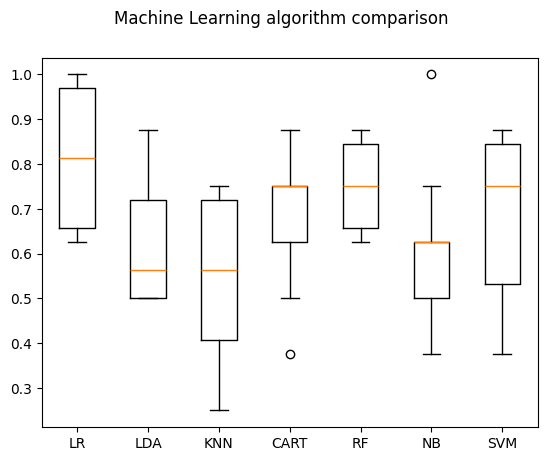

In [21]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [22]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

In [23]:
clf.fit(trainDataGlobal, trainLabelsGlobal)

RandomForestClassifier(random_state=9)

In [24]:
y_predict=clf.predict(testDataGlobal)

In [25]:
y_predict

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
      dtype=int64)

In [26]:
cm = confusion_matrix(testLabelsGlobal,y_predict)

<Axes: >

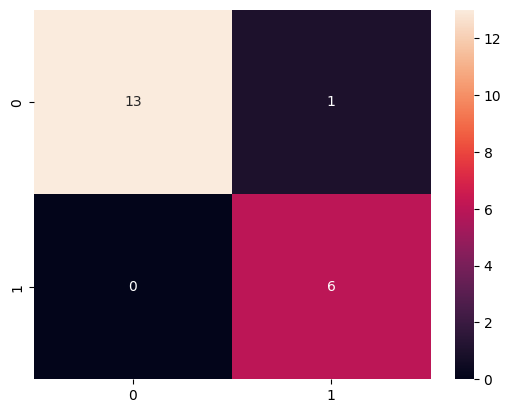

In [27]:
import seaborn as sns
sns.heatmap(cm ,annot=True)

In [28]:
print(classification_report(testLabelsGlobal,y_predict))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.86      1.00      0.92         6

    accuracy                           0.95        20
   macro avg       0.93      0.96      0.94        20
weighted avg       0.96      0.95      0.95        20



In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(testLabelsGlobal, y_predict)

0.95